In [60]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, RandomSampler
import numpy as np
from deep_feature_reweighting.wb_data import (
    WaterBirdsDataset,
    get_loader,
    get_transform_cub,
)
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [61]:
class IdxDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (idx, *self.dataset[idx])

In [62]:
DATA_FOLDER = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2"
CONCEPT_PATH = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/img_embeddings_thre10_vocab144.pickle"
VOCAB_PATH = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/vocab_thre10_144.pickle"
batch_size = 128
train_transform = get_transform_cub(
        target_resolution=(224, 224), train=True, augment_data=True
    )
test_transform = get_transform_cub(
    target_resolution=(224, 224), train=False, augment_data=False
)
trainset = WaterBirdsDataset(
        basedir=DATA_FOLDER,
        split="train",
        transform=train_transform,
        concept_embed=CONCEPT_PATH
    )
trainset_ref = WaterBirdsDataset(
        basedir=DATA_FOLDER,
        split="train",
        transform=test_transform,
        concept_embed=CONCEPT_PATH
    )
train_idx_dataset = IdxDataset(trainset_ref)
train_loader = DataLoader(
                trainset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )
ref_train_loader = DataLoader(
                train_idx_dataset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )

testset = WaterBirdsDataset(
    basedir=DATA_FOLDER,
    split="test",
    transform=test_transform,
    concept_embed=CONCEPT_PATH
)
test_loader = DataLoader(
                testset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )

11788
4795
11788
4795
11788
5794


/u/gz5hp/ml/lib/python3.10/site-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [63]:
device  = "cuda:0"
model = torchvision.models.resnet50(weights=None)
d = model.fc.in_features
model.fc = torch.nn.Linear(d, 2)
ckpt_path = "/bigtemp/gz5hp/spurious_correlations/dfr_ckpts/waterbirds/erm_seed1/final_checkpoint.pt"
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [64]:
def get_correlated_features(model, dataloader):
    class_wise_data = {}
    model.eval()
    with torch.no_grad():
        for idx, data, y, _, _, _ in tqdm(dataloader):
            logits = model(data.to(device))
            logits = logits.detach().cpu()
            preds = torch.argmax(logits, dim=1).numpy()
            for i in range(len(y)):
                l = y[i].item()
                if l in class_wise_data:
                    class_wise_data[l].append((idx[i].item(),int(preds[i]==l)))
                else:
                    class_wise_data[l] = [(idx[i].item(),int(preds[i]==l))]
    embeddings = dataloader.dataset.dataset.embeddings  
    class_correlated_feas = {}
    for c in class_wise_data:
        num_per_class = len(class_wise_data[c])
        counts_pos_w = np.zeros(embeddings.shape[1])
        counts_neg_w = np.zeros(embeddings.shape[1])
        
        counts_pos_wo = np.zeros(embeddings.shape[1])
        counts_neg_wo = np.zeros(embeddings.shape[1])
        for idx, pred_res in class_wise_data[c]:
            if pred_res == 1:
                counts_pos_w[embeddings[idx] == 1] += 1
                counts_pos_wo[embeddings[idx] != 1] += 1
            else:
                counts_neg_w[embeddings[idx] == 1] += 1
                counts_neg_wo[embeddings[idx] != 1] += 1
                
            
        indexes = np.arange(embeddings.shape[1])
        active_feas = indexes[(counts_pos_w + counts_neg_w) > 0]
        total_w = counts_pos_w[active_feas] + counts_neg_w[active_feas]
        probs_w = counts_pos_w[active_feas] / total_w
        
        total_wo = counts_pos_wo[active_feas] + counts_neg_wo[active_feas]
        probs_wo = counts_pos_wo[active_feas] / (total_wo + 1e-10)
        
        scores = np.tanh(abs(np.log(probs_w / (probs_wo+1e-10)+1e-10)))
        class_correlated_feas[c] = (scores, active_feas)
    return class_correlated_feas      
    
    

In [65]:
with open(VOCAB_PATH, "rb") as f:
    vocab = pickle.load(f)


In [66]:
class_correlated_feas = get_correlated_features(model, ref_train_loader)

100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


In [67]:
fea_indexes = class_correlated_feas[1][1][np.argsort(class_correlated_feas[1][0])]
[vocab[i] for i in fea_indexes]

['white:adj',
 'large:adj',
 'bird:noun',
 'top:noun',
 'duck:noun',
 'person:noun',
 'beach:noun',
 'black:adj',
 'water:noun',
 'woman:noun',
 'seagull:noun',
 'body:noun',
 'colorful:adj',
 'flower:noun',
 'bike:noun',
 'pole:noun',
 'head:noun',
 'dirt:noun',
 'post:noun',
 'dirt road:noun',
 'elephant:noun',
 'giraffe:noun',
 'picnic:noun',
 'flower pot:noun',
 'beak:noun',
 'long:adj',
 'picnic table:noun',
 'metal:noun',
 'city:noun',
 'bunch:noun',
 'pot:noun',
 'sidewalk:noun',
 'red:adj',
 'leave:noun',
 'skateboard:noun',
 'horse:noun',
 'ground:noun',
 'boy:noun',
 'wall:noun',
 'back:noun',
 'grass field:noun',
 'wood:noun',
 'waterfall:noun',
 'polar:adj',
 'sand:noun',
 'table:noun',
 'crowd:noun',
 'ledge:noun',
 'day:noun',
 'mountain:noun',
 'hillside:noun',
 'cat:noun',
 'bridge:noun',
 'umbrella:noun',
 'fish:noun',
 'palm tree:noun',
 'palm:noun',
 'dry:adj',
 'sky:noun',
 'flock:noun',
 'blue:adj',
 'mouth:noun',
 'side:noun',
 'little:adj',
 'wooden:adj',
 'girl:

<BarContainer object of 116 artists>

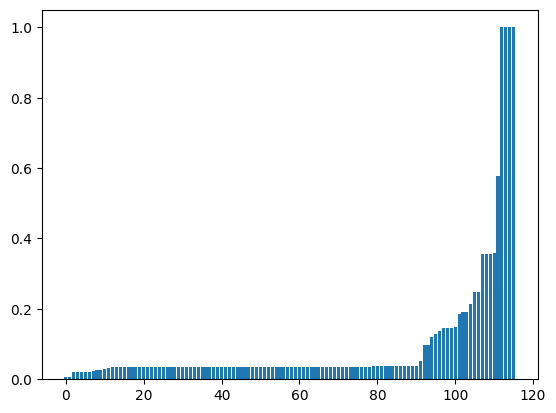

In [68]:
plt.bar(np.arange(len(class_correlated_feas[1][0])), np.sort(class_correlated_feas[1][0]))

In [75]:
           
class DecoderDataset(Dataset):
    def __init__(self, dataset, feature_indexes):
        self.dataset = dataset
        all_indexes = np.arange(len(dataset.embeddings))
        sel_indexes = []
        labels = []
        features = []
        for c in feature_indexes:
            features.append(feature_indexes[c])
        features = np.unique(np.concatenate(features))
        # self.labels = np.zeros(len(all_indexes),dtype=np.int64)
        # cond = dataset.embeddings[:,features].sum(axis=1) > 0
        # indexes = all_indexes[cond]
        # self.labels[indexes] = 1
        self.labels = dataset.embeddings[:,features].astype(np.int64)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx][0], self.labels[idx]


# learn the feature decoder
fea_indexes = {}
for c in class_correlated_feas:
    indexes = class_correlated_feas[c][1][np.argsort(class_correlated_feas[c][0])]
    fea_indexes[c] = indexes[-10:]
decoder_dataset = DecoderDataset(trainset, fea_indexes)
decoder_train_loader = DataLoader(
                decoder_dataset,
                batch_size=batch_size,
                pin_memory=True,
                num_workers=4,
            )
num_heads = decoder_dataset.labels.shape[1]

In [76]:
class IdentityModel(nn.Module):
    def __init__(self):
        super(IdentityModel, self).__init__()
    def forward(self, x):
        return x
class UnlearnModel(nn.Module):
    def __init__(self, num_heads):
        super(UnlearnModel, self).__init__()
        model = torchvision.models.resnet50(weights=None)
        d = model.fc.in_features
        identity_layer = IdentityModel()
        self.backbone = model
        self.backbone.fc = identity_layer
        
        self.classifier = nn.Linear(d, 2)
        self.fea_decoder = nn.ModuleList([nn.Linear(d, 2) for n in range(num_heads)])
        self.num_heads = num_heads
    def unlearn(self, x):
        with torch.no_grad():
            fea = self.backbone(x)
        decs = []
        for n in range(self.num_heads):
            dec = self.fea_decoder[n](fea)
            decs.append(dec)
        return decs
    def forward(self, x):
        fea = self.backbone(x)
        decs = []
        for n in range(self.num_heads):
            dec = self.fea_decoder[n](fea)
            decs.append(dec)
        logits = self.classifier(fea)
        return logits, decs
umodel = UnlearnModel(num_heads)
umodel.backbone.load_state_dict(torch.load(ckpt_path), strict=False)
umodel.to(device)

UnlearnModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [77]:
umodel.eval()
umodel.fea_decoder.train()
loss_func = nn.CrossEntropyLoss()
decoder_optimizer = torch.optim.SGD(
        umodel.fea_decoder.parameters(), lr=1.e-3, momentum=0.9, weight_decay=1e-4
)
for epoch in range(20):
    loss_avg = 0.0
    acc_avg = np.zeros(num_heads)
    counts = 0
    for data, y in tqdm(decoder_train_loader):
        data = data.to(device)
        y = y.to(device)
        decs = umodel.unlearn(data)
        loss = 0.0
        for n in range(len(decs)):
            loss += loss_func(decs[n], y[:,n])
        decoder_optimizer.zero_grad()
        loss.backward()
        decoder_optimizer.step()
        loss_avg += loss.item()
        counts += len(y)
        for n in range(len(decs)):
            acc_avg[n] += (torch.argmax(decs[n], dim=1) == y[:,n]).sum().item()
    acc_avg /= counts
    loss_avg /= counts
    print(f"Epoch {epoch} loss {loss_avg:.4f} acc_avg {acc_avg.mean():.4f}")
    

100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch 0 loss 0.0201 acc_avg 0.9578


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch 1 loss 0.0121 acc_avg 0.9759


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch 2 loss 0.0108 acc_avg 0.9765


100%|██████████| 38/38 [00:08<00:00,  4.46it/s]


Epoch 3 loss 0.0104 acc_avg 0.9769


100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch 4 loss 0.0101 acc_avg 0.9773


100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


Epoch 5 loss 0.0099 acc_avg 0.9776


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch 6 loss 0.0097 acc_avg 0.9777


100%|██████████| 38/38 [00:08<00:00,  4.57it/s]


Epoch 7 loss 0.0096 acc_avg 0.9778


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch 8 loss 0.0095 acc_avg 0.9783


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch 9 loss 0.0094 acc_avg 0.9783


100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch 10 loss 0.0093 acc_avg 0.9785


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


Epoch 11 loss 0.0092 acc_avg 0.9785


100%|██████████| 38/38 [00:08<00:00,  4.46it/s]


Epoch 12 loss 0.0092 acc_avg 0.9787


100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch 13 loss 0.0090 acc_avg 0.9790


100%|██████████| 38/38 [00:08<00:00,  4.40it/s]


Epoch 14 loss 0.0091 acc_avg 0.9786


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch 15 loss 0.0089 acc_avg 0.9791


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch 16 loss 0.0089 acc_avg 0.9789


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch 17 loss 0.0089 acc_avg 0.9789


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch 18 loss 0.0089 acc_avg 0.9793


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]

Epoch 19 loss 0.0088 acc_avg 0.9795


In [79]:
#unlearn the selected features
umodel.train()
umodel.fea_decoder.eval()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
        list(umodel.backbone.parameters())+list(umodel.classifier.parameters()), lr=1.e-5, momentum=0.9, weight_decay=1e-4
)
for epoch in range(50):
    loss_avg = 0.0
    acc_avg = 0.0
    counts = 0
    for data, y, _, _, _ in tqdm(train_loader):
        data = data.to(device)
        y = y.to(device)
        ref_y = (torch.ones(len(y),2)/2.0).to(device)
        logits, decs = umodel(data)
        loss1 = loss_func(logits, y)
        loss2 = 0.0
        for n in range(len(decs)):
            loss2 += loss_func(decs[n], ref_y)

        loss = loss1 + loss2/num_heads * 0.2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        counts += len(y)
        corrects = (torch.argmax(logits, dim=1) == y).sum().item()
        acc_avg += corrects
    acc_avg /= counts
    loss_avg /= counts
    print(f"Epoch {epoch} loss {loss_avg:.4f} acc_avg {acc_avg:.4f}")
umodel.fea_decoder.train()
loss_func = nn.CrossEntropyLoss()


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 0 loss 0.0060 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 1 loss 0.0060 acc_avg 0.7662


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 2 loss 0.0060 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 3 loss 0.0060 acc_avg 0.7670


100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


Epoch 4 loss 0.0060 acc_avg 0.7670


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 5 loss 0.0060 acc_avg 0.7666


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 6 loss 0.0060 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 7 loss 0.0059 acc_avg 0.7668


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 8 loss 0.0059 acc_avg 0.7664


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 9 loss 0.0059 acc_avg 0.7677


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 10 loss 0.0059 acc_avg 0.7673


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 11 loss 0.0059 acc_avg 0.7664


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 12 loss 0.0059 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 13 loss 0.0059 acc_avg 0.7673


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 14 loss 0.0059 acc_avg 0.7673


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 15 loss 0.0059 acc_avg 0.7668


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 16 loss 0.0059 acc_avg 0.7675


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 17 loss 0.0059 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 18 loss 0.0058 acc_avg 0.7675


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 19 loss 0.0058 acc_avg 0.7673


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 20 loss 0.0058 acc_avg 0.7666


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 21 loss 0.0058 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 22 loss 0.0058 acc_avg 0.7666


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 23 loss 0.0058 acc_avg 0.7670


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 24 loss 0.0058 acc_avg 0.7677


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 25 loss 0.0058 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 26 loss 0.0058 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 27 loss 0.0058 acc_avg 0.7675


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 28 loss 0.0058 acc_avg 0.7666


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 29 loss 0.0058 acc_avg 0.7673


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 30 loss 0.0058 acc_avg 0.7675


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 31 loss 0.0058 acc_avg 0.7670


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 32 loss 0.0057 acc_avg 0.7670


100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 33 loss 0.0058 acc_avg 0.7668


100%|██████████| 38/38 [00:17<00:00,  2.12it/s]


Epoch 34 loss 0.0057 acc_avg 0.7670


100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 35 loss 0.0057 acc_avg 0.7668


100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


Epoch 36 loss 0.0057 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 37 loss 0.0057 acc_avg 0.7673


100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 38 loss 0.0057 acc_avg 0.7673


100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 39 loss 0.0057 acc_avg 0.7675


100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 40 loss 0.0057 acc_avg 0.7664


100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


Epoch 41 loss 0.0057 acc_avg 0.7664


100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 42 loss 0.0057 acc_avg 0.7664


100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


Epoch 43 loss 0.0057 acc_avg 0.7670


100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 44 loss 0.0057 acc_avg 0.7670


100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 45 loss 0.0057 acc_avg 0.7673


100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 46 loss 0.0057 acc_avg 0.7670


100%|██████████| 38/38 [00:18<00:00,  2.04it/s]


Epoch 47 loss 0.0056 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 48 loss 0.0057 acc_avg 0.7666


100%|██████████| 38/38 [00:18<00:00,  2.02it/s]

Epoch 49 loss 0.0056 acc_avg 0.7670


In [ ]:
def test_model(model, loader):
    count = 0
    acc = 0
    model.eval()
    res = []
    groups = []
    with torch.no_grad():
        for x, y, g, p, _ in loader:
            x, y = (
                x.to(device),
                y.to(device),
            )  # 1 for water; 0 for land. 1 for seabird; 0 for landbird.
            out, _ = model(x)
            pred = (torch.argmax(out, dim=-1) == y).detach().cpu().numpy()
            res.append(pred)
            groups.append(g.detach().cpu().numpy())
    res = np.concatenate(res)
    groups = np.concatenate(groups)
    avg_acc = res.sum() / len(res)
    acc_group = []
    group_num = []
    for g in np.unique(groups):
        gres = res[groups == g]
        acc_group.append(gres.sum() / len(gres))
        group_num.append(len(gres))
    acc_group = np.array(acc_group)
    worst_acc = acc_group.min()
    # print(group_num)
    return avg_acc, worst_acc

In [ ]:
avg_acc, worst_acc = test_model(umodel, test_loader)
print(f"avg_acc {avg_acc:.4f} worst_acc {worst_acc:.4f}")

avg_acc 0.9165 worst_acc 0.7648


In [ ]:
# single decoder layer: avg_acc 0.9113 worst_acc 0.5576 (20, 20), alpha = 0.1
# two-layer decoder: avg_acc 0.9261 worst_acc 0.5935 (20, 20), alpha = 0.1
# two-layer decoder (256 hidden units): avg_acc 0.9115 worst_acc 0.7819 (50, 50)-epoch, alpha = 0.1
# two-layer decoder (512 hidden units): avg_acc 0.9104 worst_acc 0.7586 (50, 50)-epoch, alpha = 0.1
# two-layer decoder (256 hidden units): avg_acc 0.9213 worst_acc 0.7928 (50, 50)-epoch, alpha = 0.2
# two-layer decoder (256 hidden units): avg_acc 0.9239 worst_acc 0.7866, alpha = 0.5

In [6]:
import pickle
from tqdm import tqdm
import numpy as np

In [12]:
len(captions)

11787

In [14]:
path = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/vit-gpt2_captions.csv"
meta_path = "/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/metadata.csv"
captions = [x.strip() for x in open(path, "r").readlines()]
meta_data = [x.strip() for x in open(meta_path, "r").readlines()][1:]
with open("/bigtemp/gz5hp/dataset_hub/waterbird_complete95_forest2water2/vit-gpt2_captions_new.csv", "w") as f:
    for i in range(len(meta_data)):
        label = meta_data[i].split(',')[2].strip()
        eles = captions[i].split(',')
        sel_data = [eles[1].split('/')[-1], eles[-1], label]
        f.write(','.join(sel_data)+'\n')


In [9]:
concept_arr

[(0, '1', []),
 (1, '2', []),
 (2, '3', []),
 (3, '4', []),
 (4, '5', []),
 (5, '6', []),
 (6, '7', []),
 (7, '8', []),
 (8, '9', []),
 (9, '10', []),
 (10, '11', []),
 (11, '12', []),
 (12, '13', []),
 (13, '14', []),
 (14, '15', []),
 (15, '16', []),
 (16, '17', []),
 (17, '18', []),
 (18, '19', ['lake:noun']),
 (19, '20', []),
 (20, '21', []),
 (21, '22', []),
 (22, '23', ['lake:noun']),
 (23, '24', ['lake:noun']),
 (24, '25', ['lake:noun']),
 (25, '26', []),
 (26, '27', []),
 (27, '28', []),
 (28, '29', []),
 (29, '30', ['lake:noun']),
 (30, '31', []),
 (31, '32', []),
 (32, '33', []),
 (33, '34', []),
 (34, '35', []),
 (35, '36', []),
 (36, '37', []),
 (37, '38', []),
 (38, '39', []),
 (39, '40', []),
 (40, '41', []),
 (41, '42', []),
 (42, '43', []),
 (43, '44', []),
 (44, '45', []),
 (45, '46', []),
 (46, '47', []),
 (47, '48', []),
 (48, '49', []),
 (49, '50', []),
 (50, '51', []),
 (51, '52', []),
 (52, '53', []),
 (53, '54', []),
 (54, '55', []),
 (55, '56', []),
 (56, '57', 